# 0.0 Imports

In [1]:
#!pip install inflection
#!pip install boruta
#!pip install tabulate
#!pip install requests

In [2]:
import inflection
import json
import math
import matplotlib
import pickle
import random
import requests
import warnings

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb

from boruta                import BorutaPy
from datetime              import datetime, timedelta, date
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate              import tabulate

## 0.1 Helper functions

In [3]:
def cramer_v (a,b):
    cm = pd.crosstab(a, b).values
    
    n = cm.sum()
    k,r = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
            #start and end date for validation
            validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
            validation_end_date = x_training['date'].max() - timedelta(days=(k-1)*6*7)

            #filtering dataset
            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

            #training and validation dataset
            #training
            xtraining = training.drop(['date','sales'],axis=1)
            ytraining = training['sales']

            #validation
            xvalidation = validation.drop(['date','sales'],axis=1)
            yvalidation = validation['sales']

            #model
            m = model.fit(xtraining, ytraining)

            #prediction
            yhat = m.predict(xvalidation)

            #performance
            m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

            #store performance of each kfold iteration
            mae_list.append(m_result['MAE'])
            mape_list.append(m_result['MAPE'])
            rmse_list.append(m_result['RMSE'])

            return pd.DataFrame({'MAE CV': [np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str)],
                                 'MAPE CV': [np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str)],
                                 'RMSE CV': [np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)]
                             })

## 0.2 Loading Data

In [4]:
df_store_raw = pd.read_csv('store.csv', low_memory=False)
df_sales_raw = pd.read_csv('train.csv', low_memory=False)

#merge
df_raw = pd.merge(df_store_raw,df_sales_raw,how='left',on='Store')

# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday']

sneakcase = lambda x: inflection.underscore (x)

cols_new = list(map(sneakcase,cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of columns:', format(df1.shape[1]))
print('Number of rows:', format(df1.shape[0]))

Number of columns: 18
Number of rows: 1017209


## 1.3 Data types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
2,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
3,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
4,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662657,-0.784436,-0.210075
7,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
8,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
9,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

store_type         4
assortment         3
promo_interval     4
state_holiday      4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

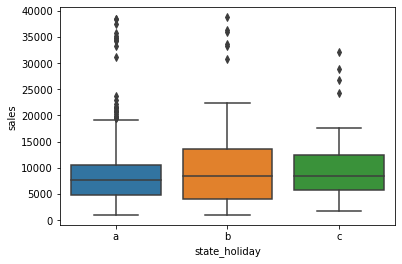

In [15]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

<AxesSubplot:xlabel='store_type', ylabel='sales'>

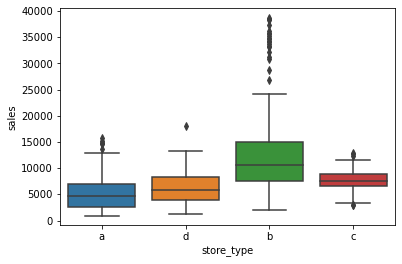

In [16]:
sns.boxplot(x='store_type', y='sales', data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

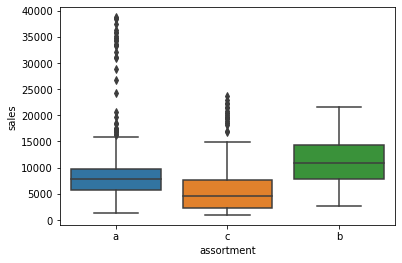

In [17]:
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

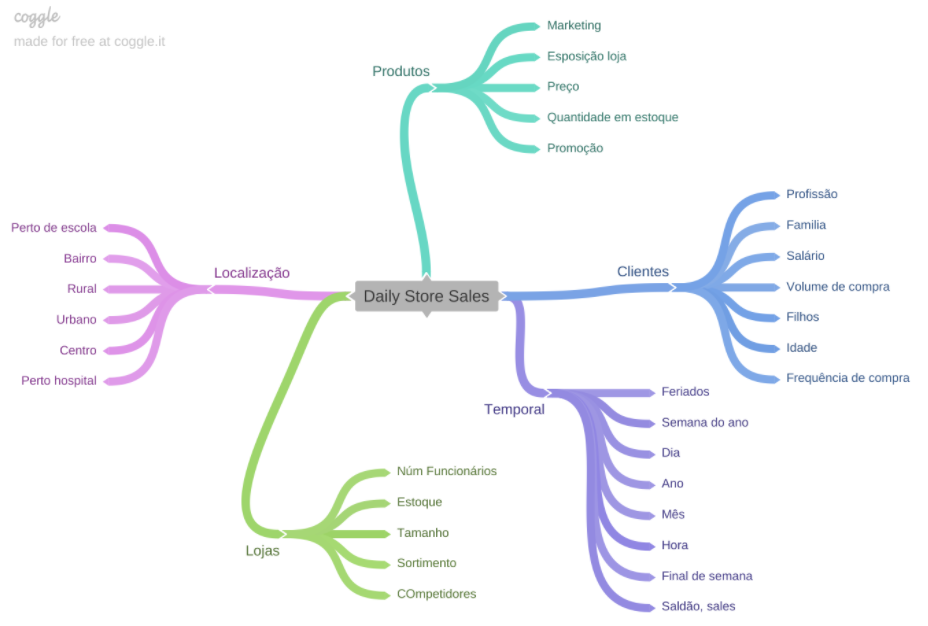

In [19]:
Image('img\MindMapHypothesis.png')


## 2.2 Hypothesis Creation

### 2.1.1 Store Hypothesis 

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com mais competidores deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com descontos maiores deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com promoções mais longas deveriam vender mais.

**7.** Lojas com promoções consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo do ano.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final Hypothesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com mais competidores deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais longas deveriam vender mais.

**6.** Lojas com promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo do ano.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtering Variables

In [21]:
df3 = df2.copy()

## 3.1 Filtering lines

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtering cols

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Exploratory Data Analysis

In [24]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

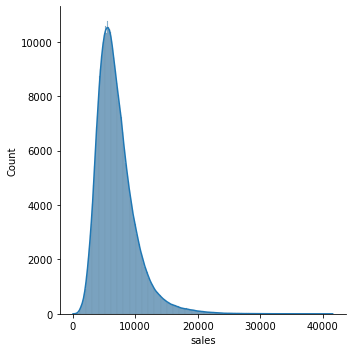

In [25]:
sns.displot(df4['sales'], kde=True)

### 4.1.2 Numeric variable

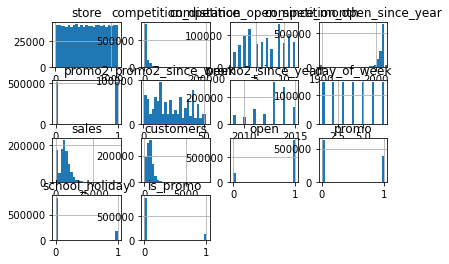

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

C:\Users\Henrique\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

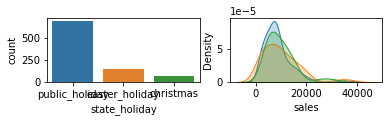

In [27]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

C:\Users\Henrique\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

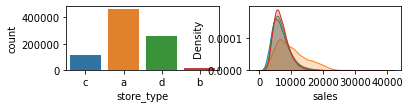

In [28]:
#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

C:\Users\Henrique\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

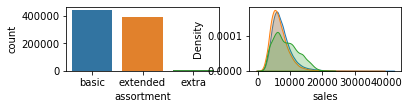

In [29]:
#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
FALSO com lojas mais sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

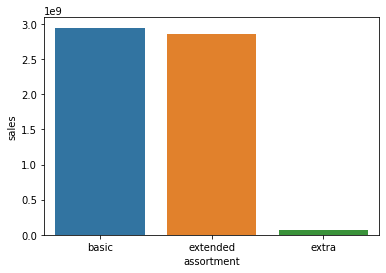

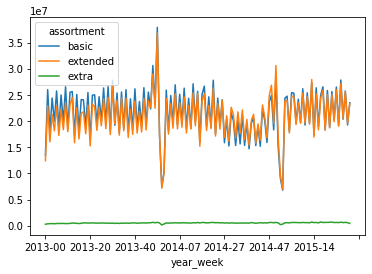

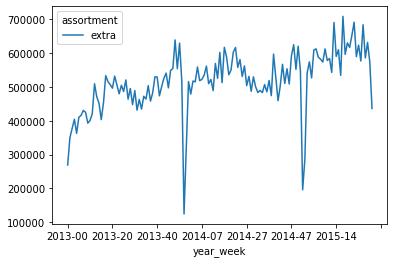

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2. Lojas com mais competidores deveriam vender menos.
FALSO lojas com mais competidores vendem mais

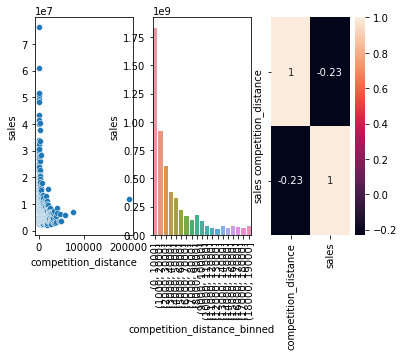

In [31]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
#x.set_xlim(bottom+0.5, top-0.5)

### H3. Lojas com competidores à mais tempo deveriam vender mais.
FALSO lojas com competidores a mais tempo vendem mais

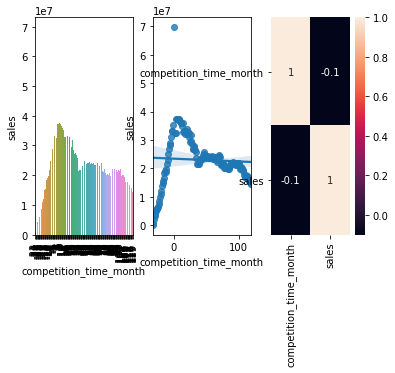

In [32]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSO lojas com promoções extendidas vendem menos, depois de algum tempo

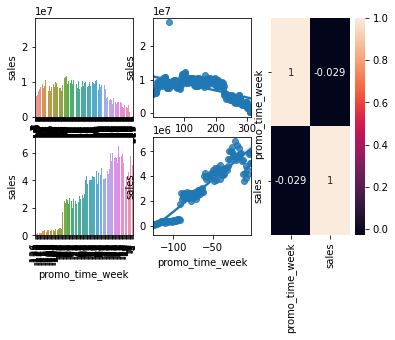

In [33]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gs.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com promoções mais longas deveriam vender mais. </s>

### H6. Lojas com promoções consecutivas deveriam vender mais.
FALSO lojas com promoções consecutivas vendem menos

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


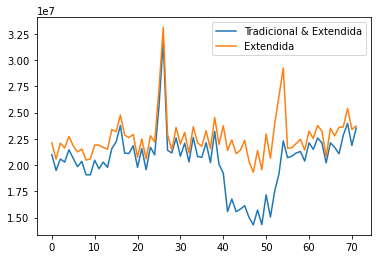

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### H7. Lojas abertas durante o Natal deveriam vender mais.
FALSO lojas que abrem no natal vendem menos

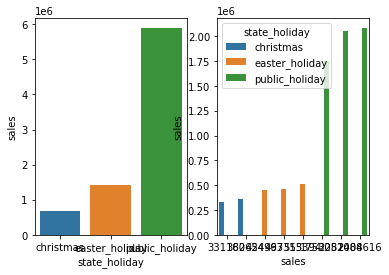

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='sales', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo do ano.
FALSO lojas vendem menos durante os anos

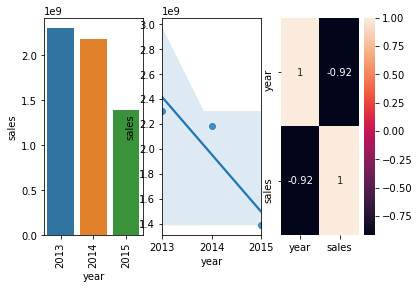

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
FALSO lojas vendem menos no segundo semestre

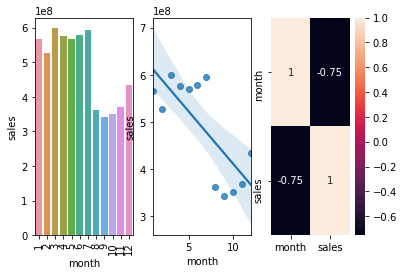

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRO lojas vendem mais depois do dia 10

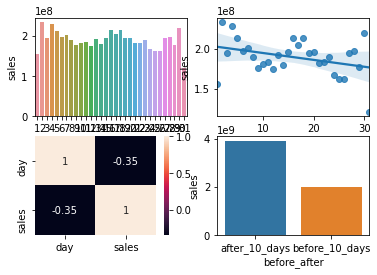

In [39]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);
#plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
VERDADEIRO lojas vendem menos aos finais de semana

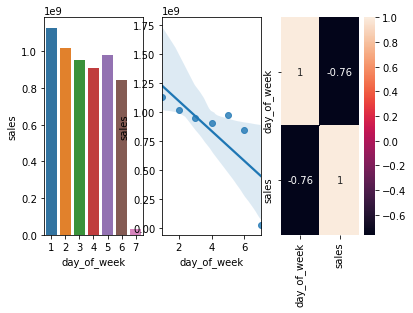

In [40]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);
#plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRO lojas vendem menos durante os feriados escolares, exceto julho e agosto

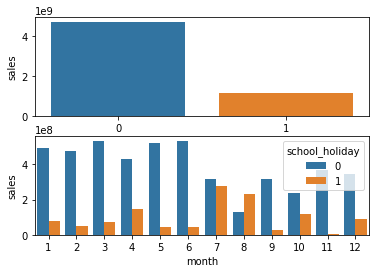

In [41]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

In [42]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

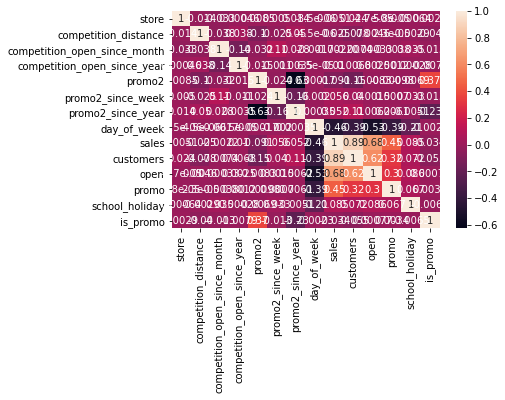

In [43]:
correlations = num_attributes.corr(method='pearson')
sns.heatmap(correlations,annot=True);

### 4.2.1 Resumo

### 4.3.2 Categorical Attributes

<AxesSubplot:>

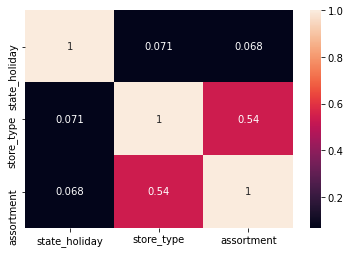

In [44]:
#only categorical data
a = df4.select_dtypes(include='object')

#calculate cramer v
a1 = cramer_v (a['state_holiday'], a['state_holiday'])
a2 = cramer_v (a['state_holiday'], a['store_type'])
a3 = cramer_v (a['state_holiday'], a['assortment'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])

a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

#finald ataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                 'store_type': [a4,a5,a6],
                 'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)

#heat map
sns.heatmap(d,annot=True)

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalização

**Não tem variável com distribuição normal**

## 5.2 Rescaling

In [73]:
#a = df5.select_dtypes(include=['float64','int64'])

rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('competition_distance_scaler.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('competition_time_month_scaler.pkl', 'wb'))

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('year_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [52]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [53]:
df5['sales'] = np.log(df5['sales'])

### 5.3.3 Nature Transformation

In [54]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6.0 Feature Selection

In [55]:
df6 = df5.copy()

## 6.1 Split Dataframe into test and training dataset

In [56]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}\n'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [57]:
#training and test dataset for Boruta
x_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

### 6.2.1 Best feature from Boruta

In [58]:
#cols_selected = boruta.support_.tolist()

#best feature
#x_train_fs = x_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
#cols_selected_boruta

#not selected from Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [59]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                        'week_of_year_sin','week_of_year_cos']

#columns to add
feat_to_add = ['date','sales']

#final feature
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modeling

In [60]:
x_train = X_train[cols_selected_boruta]
x_test = X_test [cols_selected_boruta]

#time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.413085,1835.141019


## 7.2 Linear Regression Model

In [62]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.086951,0.292756,2671.056821


### 7.2.1 Linear Regression Model

In [63]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [64]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.373796,0.289248,2747.58043


### 7.3.1 Lasso - Cross Validation

In [65]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

## 7.4 Random Forest Regressor

In [66]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

KeyboardInterrupt: 

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv

## 7.5 XGBoost

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XGBoost - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [ ]:
#warnings.filterwarnings('ignore')

#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         #'eta': [0.01, 0.03],
         #'max_depth': [3, 5, 9],
         #'subsample': [0.1, 0.5, 0.7],
         #'colsample_bytree': [0.3, 0.7, 0.9],
         #'min_child_weight': [3, 8, 15]}

#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
  #choose values for parameters randomly
#  hp = {k: random.sample(v,1)[0] for k, v in param.items()}
 # print(hp)

  #model
 # model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                          #  n_estimators = hp['n_estimators'],
                          #  eta = hp['eta'],
                          #  max_depth = hp['max_depth'],
                          # subsample = hp['subsample'],
                          #  colsample_bytee = hp['colsample_bytree'])

  #performance
  #result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
  #final_result = pd.concat([final_result, result])

#final_result

## 8.2 Final Result

In [ ]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 3}

In [ ]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators = param_tuned['n_estimators'],
                            eta = param_tuned['eta'],
                            max_depth = param_tuned['max_depth'],
                            subsample = param_tuned['subsample'],
                            colsample_bytee = param_tuned['colsample_bytree']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

# 9.0 Translation and interpretation error

In [ ]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
#sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3, how='inner', on='store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions', 'worst_scenario','best_scenario','MAE','MAPE']]

In [ ]:
df92.sort_values('MAPE',ascending=False).head()

In [ ]:
sns.scatterplot(x='store',y='MAPE', data=df92)

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scneario', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

## 9.3 ML Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['error'])

# 10.0 Deploy model to production

In [62]:
#saved trained model
pickle.dump(model_xgb_tuned, open('model_rossmann.pkl','+wb'))

NameError: name 'model_xgb_tuned' is not defined

## 10.1 Rossmann Class

In [75]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann (object):
    def __init__(self):
        self.home_path = 'C:/Users/Henrique/data_science_producao/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        #1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        sneakcase = lambda x: inflection.underscore (x)
        cols_new = list(map(sneakcase,cols_old))
        df1.columns = cols_new
    
        #1.3 Data types
        df1['date'] = pd.to_datetime(df1['date'])

        #1.5 Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Oct', 11:'Nov', 12:'Dec'}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        #1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        #2.4 Feature Engineering
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week_of_year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        #year_week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition_since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        #3.0 Filtering Variables
        #3.1 Filtering lines
        df2 = df2[df2['open'] != 0]

        #3.2 Filtering cols
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        #5.2 Rescaling
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        #5.3.1 Encoding
        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #5.3.3 Nature Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                            'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                            'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                            'week_of_year_sin','week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')


## 10.2 API Handler

In [109]:
import pickle
import pandas as pd
from flask    import Flask, request, Response
from rossmann.Rossmann import Rossmann
import os

#loading model
model = pickle.load(open('C:/Users/Henrique/data_science_producao/model/model_rossmann.pkl','rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        #instantiate Rossmann Class
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run()


ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [7]:
#loading test dataset
df10 = pd.read_csv('test.csv')

In [15]:
#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([24,12,22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)
#df_test = df_test.drop('Sales', axis=1)
#df_test = df_test.drop('Customers', axis=1)

In [16]:
#convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [17]:
#API call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-modelv1.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [18]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [20]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
d2
#for i in range(len(d2)):
   # print('Store Nummber: {} will sell ${:, .2f} in the next 6 weeks'.format(
       # d2.iloc[i, 'store'],
        #d2.iloc[i, 'prediction']))

,store,prediction
0,12,266909.095215
1,22,146022.898682
2,24,314016.586426
